# MCMC (Markov Chain Monte Carlo)

GPflow allows you to approximate the posterior over the latent functions of its models (and hyperparemeter after setting a prior for those) using Hamiltonian Monte Carlo (HMC)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow_probability as tfp

import gpflow
from gpflow.ci_utils import ci_niter, is_continuous_integration
from multiclass_classification import plot_from_samples, colors

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = lambda x: gpflow.config.to_default_float(x)

%matplotlib inline

### Table of Contents

In this notebooks, we provide 3 examples
* [Example 1](#example_1): Sampling hyperparameters in GP regression
* [Example 2](#example_2): Sparse Variational MC applied to the multiclass classification problem
* [Example 3](#example_3): Full Bayesian inference for GP models

<a id='example_1'></a>
## Example 1: GP Regression

We first consider the GP regression (with Gaussian noise) for which the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

The GPR model parameterized by $\theta = [\tau]$ is given by
$$ Y_i = f(X_i) + \varepsilon_i$$
where $f \sim \mathcal{GP}(\mu(.), k(., .))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

See the [GPR notebook](../basics/regression.ipynb) for more details on GPR and for a treatment of the direct likelihood maximization.



#### Data for a 1-dimensional regression problem

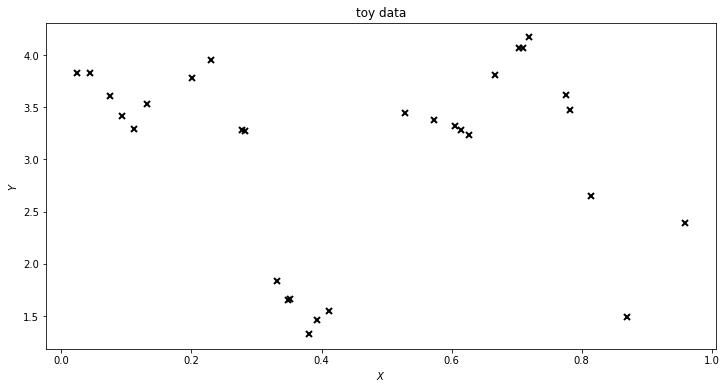

In [2]:
N = 30
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
data = (X, Y)

plt.figure(figsize=(12,6))
plt.plot(X, Y, 'kx', mew=2)
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('toy data')
plt.show()

#### MCMC for hyperparameters $\theta$

We now want to sample from the posterior over $\theta$: 
$$p(\theta|\mathbf{y}) \propto p(\mathbf{y}|\theta)p(\theta)$$

First, we build the GPR model

In [3]:
k = gpflow.kernels.Matern52(lengthscale=0.3)

meanf = gpflow.mean_functions.Linear(1.0, 0.0)
m = gpflow.models.GPR(data, k, meanf)
m.likelihood.variance.assign(0.01)

Second, we initialize the model to the maximum likelihood solution.

In [4]:
o = gpflow.optimizers.Scipy()

@tf.function(autograph=False)
def objective():
    return m.neg_log_marginal_likelihood()
o.minimize(objective, variables=m.trainable_variables)

print(f'log likelihood at optimum: {m.log_likelihood()}')

log likelihood at optimum: -0.656267049526079


Third, we add priors to the hyperparameters

In [5]:
# tfp.distributions dtype is inferred from parameters - so convert to 64-bit
m.kernel.lengthscale.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
m.kernel.variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
m.likelihood.variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
m.mean_function.A.prior = tfp.distributions.Normal(f64(0.), f64(10.))
m.mean_function.b.prior = tfp.distributions.Normal(f64(0.), f64(10.))

gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,,True,"(1, 1)",float64,[[-0.93703546]]
GPR.mean_function.b,Parameter,,True,(),float64,3.5039580386115063
GPR.kernel.variance,Parameter,Softplus,True,(),float64,0.8035348261789101
GPR.kernel.lengthscale,Parameter,Softplus,True,(),float64,0.09711003428712794
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,0.0038080092661772454


We now sample from the posterior using HMC

In [6]:
# def mcmc_target_log_prob_fn_helper(variables_list, log_prob_target_fn):

#     @tf.custom_gradient
#     def target_log_prob_fn(*variables):
#         for v_old, v_new in zip(variables_list, variables):
#             v_old.assign(v_new)

#         with tf.GradientTape(watch_accessed_variables=False) as tape:
#             tape.watch(variables_list)
#             log_prob = log_prob_target_fn()

# #         @tf.function
#         def grad_fn(in_grad, variables = None):
#             tf.print(">>>>>>>>>>>>>>>>>>>>")
#             grad = tape.gradient(log_prob, variables_list)
#             tf.print("<<<<<<<<<<<<<<<<<<<<<<<<")
#             return grad, [None] * len(variables)
#         return log_prob, grad_fn
    
#     return target_log_prob_fn

In [12]:
target_log_prob_fn = lambda : -m.neg_log_marginal_likelihood()

hmc_helper =  gpflow.optimizers.SamplingHelper(m.parameters, target_log_prob_fn )


hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75),
                                                 adaptation_rate=0.1)

num_samples = 500

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=100,
                                 current_state=hmc_helper.current_state, kernel=adaptive_hmc,
                                 trace_fn = lambda _, pkr: pkr.inner_results.is_accepted)

samples, traces = run_chain_fn()

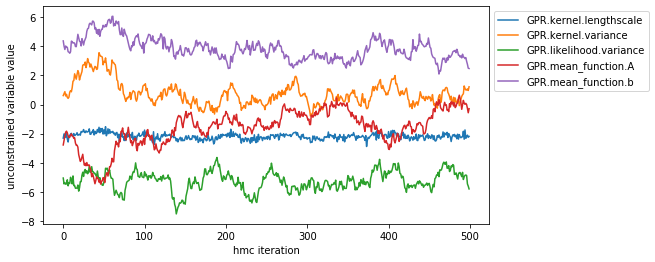

In [16]:
param_to_name = {param: name for name, param in 
                 gpflow.utilities.leaf_components(m).items()}

plt.figure(figsize=(8,4))
for val, param in zip(samples,  m.parameters):
    plt.plot(tf.squeeze(val), label=param_to_name[param])
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('unconstrained variable value');

In [17]:
gpflow.utilities.print_summary(m, fmt='notebook')


name,class,transform,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,,True,"(1, 1)",float64,[[-0.28538149]]
GPR.mean_function.b,Parameter,,True,(),float64,2.4720524872122565
GPR.kernel.variance,Parameter,Softplus,True,(),float64,1.475966951047905
GPR.kernel.lengthscale,Parameter,Softplus,True,(),float64,0.10628700951960958
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,0.003043434044030086


One can also inspect the marginal distribution of samples

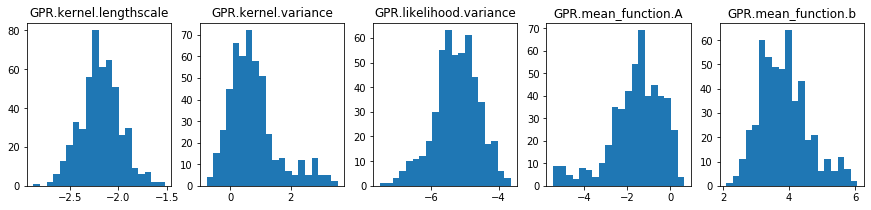

In [18]:
fig, axarr = plt.subplots(1, len(param_to_name), figsize=(15,3))
for i, param in enumerate(m.trainable_parameters):
    ax = axarr[i]
    ax.hist(np.stack(samples[i]).reshape(-1,1),bins=20)
    ax.set_title(param_to_name[param])
plt.show()



Note that the sampler runs in unconstrained space (so that positive parameters remain positive, parameters that are not trainable are ignored).
GPflow however returns a dataframe with values in the true units.

For serious analysis you most certainly want to run the sampler longer, with multiple chains and convergence checks. This will do for illustration though!


Text(0, 0.5, 'signal_variance')

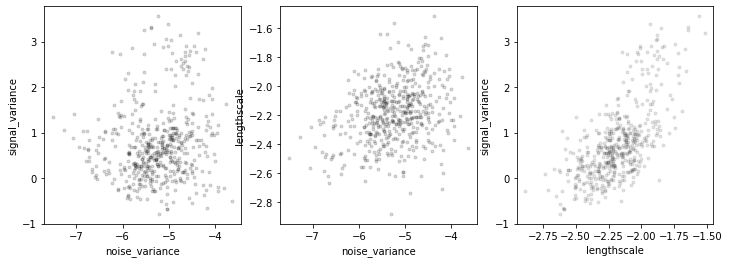

In [19]:
name_to_index = {param_to_name[param]: i for i, param in 
                 enumerate(m.trainable_parameters)}

f, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(samples[name_to_index['GPR.likelihood.variance']],
            samples[name_to_index['GPR.kernel.variance']], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')

axs[1].plot(samples[name_to_index['GPR.likelihood.variance']],
            samples[name_to_index['GPR.kernel.lengthscale']], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')

axs[2].plot(samples[name_to_index['GPR.kernel.lengthscale']],
            samples[name_to_index['GPR.kernel.variance']], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

To plot the posterior of predictions, we'll iterate through the samples and set the model state with each sample. Then, for that state (set of hyper-parameters) we'll draw some samples from the prediction function.

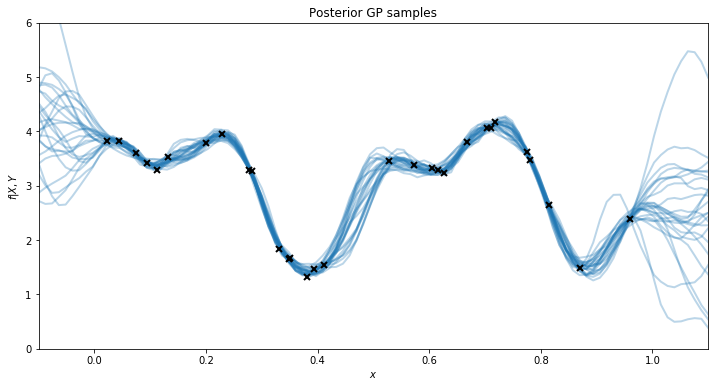

In [20]:
#plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))

for i in range(0, num_samples, 20):
    hparams = [hp[i] for hp in samples]
    [var.assign(hp) for var, hp in zip(m.trainable_variables, hparams)]
    f = m.predict_f_samples(xx, 1)
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.3)

plt.plot(X, Y, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)
plt.xlabel('$x$')
plt.ylabel('$f|X,Y$')
plt.title('Posterior GP samples')

plt.show()

<a id='example_2'></a>
## Example 2: Sparse MC for Multiclass Classification

We now consider the multiclass classification problem (see the [Multiclass notebook](../advanced/multiclass.ipynb)). Here the marginal likelihood is not available in closed form. Instead we use a sparse variational approximation where we approximate the posterior for each GP as $q(f_c) \propto p(f_c|\mathbf{u}_c)q(\mathbf{u}_c)$

In the standard SVGP formulation, $q(\mathbf{u_c})$ is parameterized as a multivariate Gaussian.

An alternative is to directly sample from the optimal $q(\mathbf{u}_c)$; this is what the SGPMC does. 

We first build a multiclass classification dataset

In [21]:
# Number of functions and number of data points
C, N = 3, 100
# Input
X = np.random.rand(N, 1)
# RBF kernel matrix
kern = gpflow.kernels.RBF(lengthscale=0.1)
K = kern.K(X) + np.eye(N) * 1e-6
# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T
# Hard max observation
Y = np.argmax(f, 1).reshape(-1,).astype(int)
# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

data = (X,Y)

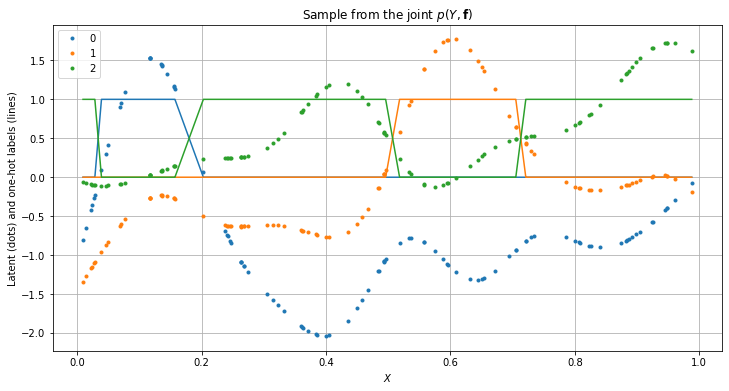

In [22]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):  
    plt.plot(X[order], f[order, c], '.', color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], '-', color=colors[c])

plt.legend()
plt.xlabel('$X$')
plt.ylabel('Latent (dots) and one-hot labels (lines)')
plt.title('Sample from the joint $p(Y, \mathbf{f})$')
plt.grid()
plt.show()

We then build the SGPMC model

In [16]:
m = gpflow.models.SGPMC(data, 
                 kernel=gpflow.kernels.Matern32(lengthscale=0.1) + gpflow.kernels.White(variance=0.01),
                 likelihood=gpflow.likelihoods.MultiClass(3),
                 inducing_variable=X[::5].copy(), num_latent=3)
m.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
m.kernel.kernels[0].lengthscale.prior = tfp.distributions.Gamma(f64(2.), f64(2.))
m.kernel.kernels[1].variance.trainable = False

gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SGPMC.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
SGPMC.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.1000000014901161
SGPMC.kernel.kernels[1].variance,Parameter,Softplus,False,(),float64,0.009999999776482648
SGPMC.likelihood.invlink.epsilon,Parameter,Sigmoid,False,(),float64,0.001000000047497451
SGPMC.inducing_variable.Z,Parameter,,True,"(20, 1)",float64,[[0.7513894...
SGPMC.V,Parameter,,True,"(20, 3)",float64,"[[0., 0., 0...."


The chain of samples for $\mathbf{u}_c, \theta$ is initialized at the value maximizing  $p(Y|\mathbf{u}_c, \theta)$

In [17]:
o = gpflow.optimizers.Scipy()

@tf.function(autograph=False)
def objective():
    return m.neg_log_marginal_likelihood()
o.minimize(objective, variables=m.trainable_variables, options={'maxiter':20})

print(f'log likelihood at optimum: {m.log_likelihood()}')

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
log likelihood at optimum: -61.822662226366496


Sampling starts with a 'burn in' period

In [18]:
ci = is_continuous_integration()
burn = 0 if ci else 100
thin = 1 if ci else 10

In [20]:
variable_list = list(m.variables)
target_log_prob_fn = mcmc_target_log_prob_fn_helper(variable_list, lambda : -m.neg_log_marginal_likelihood())
num_samples = 500

hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(hmc, num_adaptation_steps=10, target_accept_prob=f64(.75),
                                                 adaptation_rate=0.1)
@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=100,
                                 current_state=variable_list, kernel=adaptive_hmc,
                                 trace_fn = lambda _, pkr: pkr.inner_results.is_accepted)

samples, _ = run_chain_fn()

Statistics of the posterior samples can now be reported

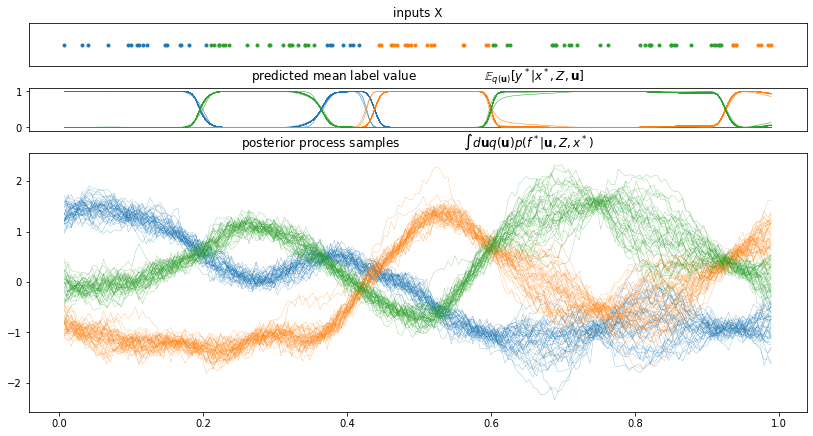

In [21]:
plot_from_samples(m, X, Y, samples, burn, thin)

One can also display the sequence of sampled hyperparameters

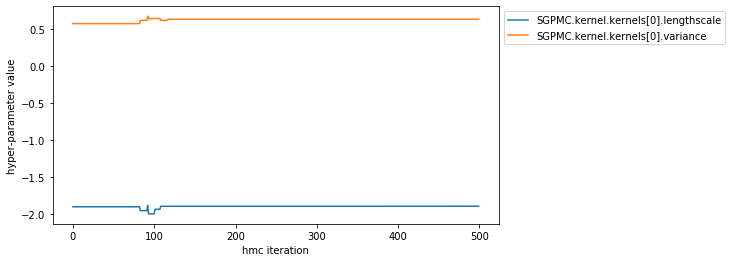

In [25]:
param_to_name = {param: name for name, param in 
                 gpflow.utilities.leaf_components(m).items()}
name_to_index = {param_to_name[param]: i for i, param in 
                 enumerate(m.trainable_parameters)}
hyperparameters = ['SGPMC.kernel.kernels[0].lengthscale',
                   'SGPMC.kernel.kernels[0].variance']

plt.figure(figsize=(8,4))
for hp in hyperparameters:
    plt.plot(samples[name_to_index[hp]], label=hp)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('hyper-parameter value');


<a id='example_3'></a>
## Example 3: Fully Bayesian inference for generalized GP models with HMC

It's possible to construct a very flexible models with Gaussian processes by combining them with different likelihoods (sometimes called 'families' in the GLM literature). This makes inference of the GP intractable since the likelihoods are not generally conjugate to the Gaussian process. The general form of the model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(m(x; \theta),\, k(x, x'; \theta))\\y_i \sim p(y | g(f(x_i))\,.$$


To perform inference in this model, we'll run MCMC using Hamiltonian Monte Carlo (HMC) over the function-values and the parameters $\theta$ jointly. Key to an effective scheme is rotation of the field using the Cholesky decomposition. We write

$$\theta \sim p(\theta)\\v \sim \mathcal {N}(0,\, I)\\LL^\top = K\\f = m + Lv\\y_i \sim p(y | g(f(x_i))\,.$$

Joint HMC over $v$ and the function values is not widely adopted in the literature becate of the difficulty in differentiating $LL^\top=K$. We've made this derivative available in tensorflow, and so application of HMC is relatively straightforward. 

### Exponential Regression
We consider and exponential regression model: 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(0, k(x, x'; \theta))\\f_i = f(x_i)\\y_i \sim \mathcal {Exp} (e^{f_i})$$

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$. first, generate a data set.

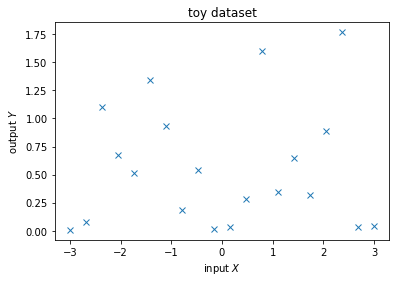

In [26]:
X = np.linspace(-3,3,20)
Y = np.random.exponential(np.sin(X)**2)

plt.figure()
plt.plot(X,Y,'x')
plt.xlabel('input $X$')
plt.ylabel('output $Y$')
plt.title('toy dataset')
plt.show()

data = (X[:,None], Y[:,None])

GPflow's model for fully-Bayesian MCMC is called GPMC. It's constructed like any other model, but contains a parameter `V` which represents the centered values of the function. 

In [27]:
k = gpflow.kernels.Matern32(1, ard=False) + gpflow.kernels.Bias(1)
l = gpflow.likelihoods.Exponential()
m = gpflow.models.GPMC(data, k, l)

The `V` parameter already has a prior applied. We'll add priors to the parameters also (these are rather arbitrary, for illustration). 

In [28]:
m.kernel.kernels[0].lengthscale.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
m.kernel.kernels[0].variance.prior =  tfp.distributions.Gamma(f64(1.), f64(1.))
m.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))

gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.V,Parameter,,True,"(20, 1)",float64,[[0....


Running HMC is pretty similar to optimizing a model. GPflow only has HMC sampling for the moment, and it's a relatively vanilla implementation (no NUTS, for example). There are two things to tune, the step size (epsilon) and the number of steps $[L_{min}, L_{max}]$. Each proposal will take a random number of steps between $L_{min}$ and $L_{max}$, each of length $\epsilon$. 

We initialize HMC at the Maximum a posteriori parameter value.

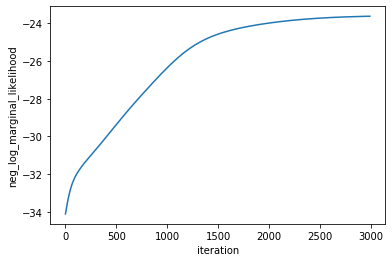

In [29]:
@tf.function(autograph=False)
def optimization_step(optimizer, model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = model.neg_log_marginal_likelihood()
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return - objective

def run_adam(model, iterations):
    logf = []
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        elbo = optimization_step(adam, m)
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

maxiter = ci_niter(3000)
logf = run_adam(m, maxiter) # start near Maximum a posteriori (MAP)

plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('neg_log_marginal_likelihood');



We then run the sampler,

In [32]:
variable_list = list(m.variables)
target_log_prob_fn = mcmc_target_log_prob_fn_helper(variable_list, lambda : -m.neg_log_marginal_likelihood())
num_samples = 500

hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(hmc, num_adaptation_steps=10, target_accept_prob=f64(.75),
                                                 adaptation_rate=0.1)
@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=100,
                                 current_state=variable_list, kernel=adaptive_hmc,
                                 trace_fn = lambda _, pkr: pkr.inner_results.is_accepted)

samples, _ = run_chain_fn()

And compute the posterior prediction on a grid for plotting purposes

In [33]:
xtest = np.linspace(-4,4,100)[:,None]
f_samples = []

for i in range(num_samples):
    hparams = [hp[i] for hp in samples]
    [var.assign(hp) for var, hp in zip(m.trainable_variables, hparams)]
    f = m.predict_f_samples(xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)

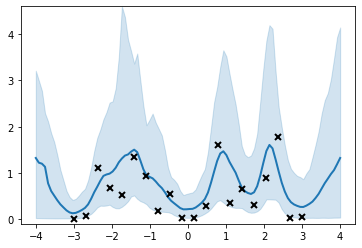

In [34]:
rate_samples = np.exp(f_samples[:, :, 0])

line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)));

One can also display the sequence of sampled hyperparameters

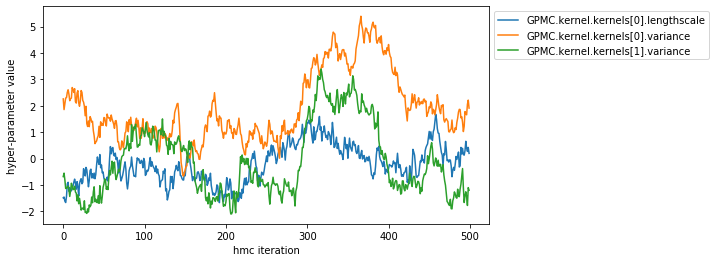

In [36]:
param_to_name = {param: name for name, param in 
                 gpflow.utilities.leaf_components(m).items()}
name_to_index = {param_to_name[param]: i for i, param in 
                 enumerate(m.trainable_parameters)}
hyperparameters = ['GPMC.kernel.kernels[0].lengthscale',
                   'GPMC.kernel.kernels[0].variance',
                   'GPMC.kernel.kernels[1].variance']

plt.figure(figsize=(8,4))
for hp in hyperparameters:
    plt.plot(samples[name_to_index[hp]], label=hp)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('hyper-parameter value');


One can also inspect the marginal of the posterior samples

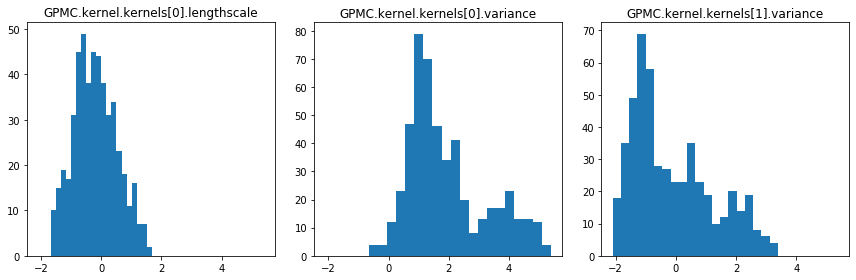

In [37]:
fig, axarr = plt.subplots(1, len(hyperparameters), sharex=True, figsize=(12,4))
for i, hyp in enumerate(hyperparameters):
    ax = axarr[i]
    ax.hist(samples[name_to_index[hyp]],bins=20)
    ax.set_title(hyp);
plt.tight_layout()